In [2]:
import numpy as np
import skimage as sk
import skimage.io as skio
import cv2
#%pylab inline
import matplotlib 
matplotlib.use('TkAgg')
from pylab import *
import scipy
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import json
import os.path
from skimage.feature import corner_harris, peak_local_max
import random
from skimage.draw import polygon

In [3]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

#from proj4a
def calc_homog_t(points_1, points_2):
    b = np.empty((0,1), int)
    A = np.zeros((2*len(points_1), 8))
    for i in range(len(points_2)):
        b = np.vstack((b, np.vstack(points_2[i])))
        x = points_1[i][0]
        y = points_1[i][1]
        x_hat = points_2[i][0]
        y_hat = points_2[i][1]
        A[2*i] = [x, y, 1, 0, 0, 0, -1*x*x_hat, -1*y*x_hat]
        A[2*i + 1] = [0, 0, 0, x, y, 1, -1*x*y_hat, -1*y*y_hat]
    x  = (np.linalg.inv((A.T)@A))@(A.T)@b
    x = np.vstack((x, 1))
    H = np.reshape(x, (3,3))
    return H


<>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-3-c3ef0739f418>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [4]:
#used to help set a threshold. the threshold should be lower than this value, but not too low.
#returns the max h_val, and counts how many are greater than the given threshold.
def find_max_h(corner_values, coords, threshold):
    maxi = -1*float('inf')
    count = 0
    for k in range(len(coords[1])):
        #print(k)
        h_val = corner_values[coords[:, k][0], coords[:, k][1]]
        if h_val >= maxi:
            maxi = h_val
        if h_val >= threshold:
            count += 1
    return maxi, count

#thresh = 0.2
#find_max_h(hc2, coords2, thresh)
# used to find a good threshold to use. first value is the max corner strength. 
# second value is the number of values above the given threshold

In [5]:
def get_filtered_corners(hc, thresh, coords):
    hc2 = hc > thresh #threshold chosen from above
    coords_filtered = np.array([[coords[:,i][0], coords[:,i][1]] for i in range(len(coords[0])) if hc2[coords[:,i][0], coords[:,i][1]]])
    len(coords_filtered) #should be the same as above
    return coords_filtered

In [6]:
%matplotlib inline
def show_corners_on_img(im, coords_filtered):
    plt.imshow(im)
    plt.scatter(coords_filtered[:, 1], coords_filtered[:, 0], s=3)
    plt.show()

In [7]:
def gen_descriptors(coords_filtered, gray):
    descriptors = []
    for coord in coords_filtered:
        x = coord[0]
        y = coord[1]
        val = gray[x-20:x+20, y-20:y+20]
        val = rescale(val, 0.2, False)
        avg = np.mean(val)
        std_dev = np.std(val)
        val = (val - avg)/std_dev
        descriptors.append(val)
    return descriptors

In [8]:
#finds matches between features in 2 images.
#uses Lowe's trick to compare the ssd of the 1-nn with the 2-nn to find good matches.
def match_features(ft_desc1, ft_desc2, thres=.4):
    mapping = {}
    all_ssd = [] #for testing purposes
    for j in range(len(ft_desc1)):  
        ft1 = ft_desc1[j]
        best_match_index = -1 
        best_match_score = float('inf')
        second_match_index = -1
        second_match_score= float('inf')
        for i in range(len(ft_desc2)):
            ft2 = ft_desc2[i]
            ssd_score = np.linalg.norm(ft1 - ft2)
            all_ssd.append(ssd_score)
            if ssd_score <= best_match_score:
                best_match_score = ssd_score
                best_match_index = i
            if ssd_score <= second_match_score and ssd_score > best_match_score:
                second_match_score = ssd_score
                second_match_index = i
        if best_match_score / second_match_score < thres:
            mapping[j] = best_match_index
    return mapping

In [9]:
# take 4 random matching features, compute an H matrix, and find the # inliers using that H. repeat this many times,
# and choose the 4 features that resulted in the most # inliers. Using this full list of inliers, do least squares
# to generate the final homography transformation.
def ransac(coords1, coords2, map_ft):
    max_inliers = -1
    best_4 = [None, None, None, None]
    best_inliers = [None]
    for _ in range(200):
        random_fts = random.sample(list(range(len(coords1))), 4)
        points_1 = []
        points_2 = []
        for i in range(4):
            points_1.append(coords1[random_fts[i]])
            points_2.append(coords2[random_fts[i]])
        H = calc_homog_t(points_1, points_2)
        num_inliers, inliers = count_inliers(H, coords1, coords2)
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_4 = random_fts
            best_inliers = inliers
    print("Found ", max_inliers, " matching inliers, out of a set of ", len(coords1), " possible feature pairs.")
    print("the best 4 randomly chosean feature indices are: ", best_4)
    good_match_coords_1 = [coords1[ind] for ind in best_inliers[0]]
    good_match_coords_2 = [coords2[ind] for ind in best_inliers[0]]
    best_H = calc_homog_t(good_match_coords_1, good_match_coords_2)
    return best_H, best_inliers

# given an H matrix, find how many coordinates in H(points_lst) are very close to points_lst_2. These points are called
# inliers if the error is less than epsilon.
def count_inliers(H, points_lst, points_lst_2, epsilon=1.2):
    count = 0
    H_t = H.T
    b = np.matrix(points_lst)
    k = np.ones((b.shape[0], 1))
    v = np.hstack((b, k))
    v_tmp = np.hstack((np.matrix(points_lst_2), k))
    new_coords = v@H_t
    new_coords[:, 0] = new_coords[:, 0] / new_coords[:, 2]
    new_coords[:, 1] = new_coords[:, 1] / new_coords[:, 2]
    new_coords[:, 2] = new_coords[:, 2] / new_coords[:, 2]
    diff = new_coords - v_tmp
    tmp = [np.abs(diff[i, 0] + diff[i, 1])  for i in range(diff.shape[0])]
    tmp2 =  np.array(tmp) < epsilon
    return np.count_nonzero(tmp2), np.where(tmp2)

In [10]:
# a more complex warping to help make bigger mosaics
# warps im using matrix H
# final_im can be used to set the full mosaic's shape, which is often alot bigger than just im's size
# c and r are used to determine the shape of the full mosaic that should be interpolated from the given image
# if we looped over the entire mosaic, 1 it would be very slow because lots of calculations are unnecessary and 2
# it would create streaks instead of just leaving the extras blank, because of how interpolation works (given a point 
# to the right of an image, it just interpolates to that edge. So the rightmost edge is repeated to the right, and same 
# for all other directions.) c and r are determined in helper_fn()
def warp(im, H, c, r, final_im):
    new_img = np.zeros((final_im.shape[0] + 500, final_im.shape[1] + 500, final_im.shape[2]))
    rows = np.arange(0, im.shape[0])
    cols = np.arange(0, im.shape[1])
    interp_1_r = scipy.interpolate.RectBivariateSpline(rows, cols, im[:, :, 0])
    interp_1_g = scipy.interpolate.RectBivariateSpline(rows, cols, im[:, :, 1])
    interp_1_b = scipy.interpolate.RectBivariateSpline(rows, cols, im[:, :, 2])
    max_x = im.shape[1]
    max_y = im.shape[0]
    
    rr, cc = polygon(r, c) #create a polygon mask for the given triangle
    lst2 = zip(cc, rr) 
    lst_tmp = zip(cc, rr)

    #a few matrix operations to stack all points in the given polygon, so they can all be transformed in one matrix multiplication
    # this is faster than individually transforming each pixel
    H_t = H.T
    b = np.matrix(list(lst2))
    #print('**** b: ', b)
    k = np.ones((b.shape[0], 1))
    v = np.hstack((b, k))
    new_coords = v@H_t
    new_coords[:, 0] = new_coords[:, 0] / new_coords[:, 2]
    new_coords[:, 1] = new_coords[:, 1] / new_coords[:, 2]
    
    #print(new_coords)
    new_vals_r = interp_1_r.ev(new_coords[:, 1], new_coords[:, 0]) #interpolate all the pixels in the triangle 
    new_img[rr,cc,0] = np.squeeze(new_vals_r)
    new_vals_g = interp_1_g.ev(new_coords[:, 1], new_coords[:, 0]) 
    new_img[rr,cc,1] = np.squeeze(new_vals_g)
    new_vals_b = interp_1_b.ev(new_coords[:, 1], new_coords[:, 0]) 
    new_img[rr,cc,2] = np.squeeze(new_vals_b)
    return new_img


In [11]:
# helps make big mosaics
# on the big mosaic, only interpolate over the polygon that is formed by warping the 4 corners of the given image
# there is no use interpolating over other pixels
# full_im determines the final mosaic's shape
def helper_fn(im, coord1, coord2, mapped_ft, full_im):
    H, inliers = ransac(coord1, coord2, mapped_ft)
    H_inv = np.matrix(H).I #used to find what shape of the big image to inverse warp over 
            #dont want to inverse warp over the entire huge image
        
    b = np.matrix([[0,0], [0, im.shape[0]], [im.shape[1], im.shape[0]], [im.shape[1], 0]])
    k = np.ones((b.shape[0], 1))
    v = np.hstack((b, k))
    new_coords = v@(H_inv.T)
    new_coords[:, 0] = new_coords[:, 0] / new_coords[:, 2]
    new_coords[:, 1] = new_coords[:, 1] / new_coords[:, 2]
    new_coords[:, 2] = new_coords[:, 2] / new_coords[:, 2]
    xs = new_coords[:,0].flatten().tolist()[0]
    ys = new_coords[:,1].flatten().tolist()[0]
    
    warped_im = warp(im, H, xs, ys, full_im)
    return warped_im, inliers[0]

In [12]:
def auto_warp(im1_file, im2_file, im_type, outfile):
    im = skio.imread(im1_file)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    hc, coords = get_harris_corners(gray)

    im2 = skio.imread(im2_file)
    gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    hc2, coords2 = get_harris_corners(gray2)
    
    if im_type=='door':
        corner_thresh=0.03
    elif im_type=='building':
        corner_thresh=0.2
    elif im_type=='outside':
        corner_thresh=0.2
        
    coords_filtered = get_filtered_corners(hc, corner_thresh, coords)
    coords_filtered2 = get_filtered_corners(hc2, corner_thresh, coords2)
    
    print("# of corners after filtering by corner strength: ", len(coords_filtered))
    
    ft_desc = gen_descriptors(coords_filtered, gray)
    ft_desc2 = gen_descriptors(coords_filtered2, gray2)
    
    if im_type=='door':
        feature_nn_ratio_thresh=0.7
    elif im_type=='building':
        feature_nn_ratio_thresh=0.6
    elif im_type=='outside':
        feature_nn_ratio_thresh=0.4
        
    map_ft = match_features(ft_desc, ft_desc2, thres=feature_nn_ratio_thresh) # creates a map of key:value = index_of_ft_1:index_of_ft_2

    coords_match_1 = [coords_filtered[k] for k in map_ft.keys()] #potentially matching coordinates of features. outlier rejection still needed
    coords_match_2 = [coords_filtered2[map_ft[k]] for k in map_ft.keys()]
    #flip x and y
    a = np.matrix(coords_match_1)
    coords_match_1 = np.array(np.hstack((a[:, 1], a[:, 0])))
    a = np.matrix(coords_match_2)
    coords_match_2 = np.array(np.hstack((a[:, 1], a[:, 0])))
    print("# of corners after feature matching: ", len(coords_match_1))
    
    full_im = np.zeros((2000, 2000, 3))
    full_im[0:im.shape[0], 0:im.shape[1], :] = im
    new_im, inliers = helper_fn(im2, coords_match_1, coords_match_2, map_ft, full_im)
    print("all inlier indices are: ", inliers)

    skio.imsave(outfile, new_im[0:full_im.shape[0], 0:full_im.shape[1], :] + full_im)
    return im, im2, hc, hc2, coords, coords2, coords_filtered, coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im 
    
    

In [432]:
im1 = 'door_left.jpg'
im2 = 'door_right.jpg'
im_type='door'
outfile = 'door_out.jpg'

im, im2, hc, hc2, coords, coords2, coords_filtered, \
coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im = \
auto_warp(im1, im2, im_type, outfile)

/Users/varunsaran/opt/anaconda3/envs/194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


# of corners after filtering by corner strength:  166
# of corners after feature matching:  70
Found  39  matching inliers, out of a set of  70  possible feature pairs.
the best 4 randomly chosean feature indices are:  [9, 13, 51, 58]


Lossy conversion from float64 to uint8. Range [-14.234777903013379, 530.7597371290647]. Convert image to uint8 prior to saving to suppress this warning.


all inlier indices are:  [ 0  1  5  6  9 10 13 14 15 17 18 20 21 22 24 26 28 29 30 32 34 36 38 39
 40 41 42 44 45 46 47 49 51 52 54 58 61 62 64]


In [434]:
#alpha blurring the 2 images so the final result is smooth
#using the same values from proj4a for blurring.

alpha_0 = np.ones(276) #276 columns of leftimage
alpha_1 = np.arange(1, 0, -1/(600-276)) #gradual blur of the 2 images over the next (600-276) columns
alpha_2 = np.zeros(500) #only image 2 for the remaining columns
alpha = np.append(alpha_0, alpha_1)
alpha = np.append(alpha, alpha_2)
full = np.copy(full_im)
tst = np.copy(new_im)

for i in range(1100):
    full[:, i, :] *= alpha[i]
    tst[:, i, :] *= (1-alpha[i])
    
skio.imsave('a_0.jpeg', full)
skio.imsave('a_1.jpeg', tst)
skio.imsave('a_2.jpeg', full + tst[0:1500, 0:1500, :])

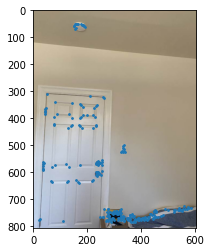

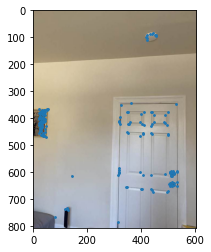

In [415]:
show_corners_on_img(im, coords_filtered[:,:])
show_corners_on_img(im2, coords_filtered2[:,:])
#all corners on each image, with no feature matching / outlier rejection

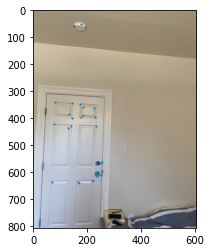

In [416]:
#show the final feature points after outlier rejection (image 1)
x = [coords_match_1[i][0] for i in inliers]
y = [coords_match_1[i][1] for i in inliers]
plt.imshow(im)
plt.scatter(x, y, s=1)
plt.show()

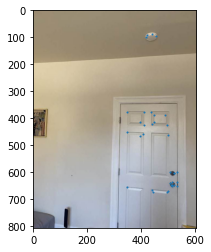

In [417]:
#show the final feature points after outlier rejection (image 2)
#there are clear correspondences with the image above, and no outliers are found.
x = [coords_match_2[i][0] for i in inliers]
y = [coords_match_2[i][1] for i in inliers]
plt.imshow(im2)
plt.scatter(x, y, s=1)
plt.show()

In [438]:
im1 = 'left.jpg'
im2 = 'right.jpg'
im_type='outside'
outfile = 'outside_out.jpg'

im, im2, hc, hc2, coords, coords2, coords_filtered, \
coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im = \
auto_warp(im1, im2, im_type, outfile)

/Users/varunsaran/opt/anaconda3/envs/194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


# of corners after filtering by corner strength:  314
# of corners after feature matching:  100
Found  78  matching inliers, out of a set of  100  possible feature pairs.
the best 4 randomly chosean feature indices are:  [59, 34, 80, 31]


Lossy conversion from float64 to uint8. Range [-21.301159113985513, 529.6124873731233]. Convert image to uint8 prior to saving to suppress this warning.


all inlier indices are:  [ 0  1  3  5  6  7 10 11 12 13 14 16 17 18 19 20 21 22 24 25 26 27 28 30
 31 32 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 56 58 59
 60 61 63 64 66 67 68 70 71 73 74 75 77 78 79 80 81 82 84 87 88 89 91 92
 93 94 95 96 97 99]


In [440]:
#alpha blurring the 2 images so the final result is smooth
alpha_0 = np.ones(340) #276 columns of leftimage
alpha_1 = np.arange(1, 0, -1/(590-340)) #gradual blur of the 2 images over the next (600-276) columns
alpha_2 = np.zeros(500) #only image 2 for the remaining columns
alpha = np.append(alpha_0, alpha_1)
alpha = np.append(alpha, alpha_2)
full = np.copy(full_im)
tst = np.copy(new_im)
for i in range(1000):
    full[:, i, :] *= alpha[i]
    tst[:, i, :] *= (1-alpha[i])

skio.imsave('c_0.jpeg', full)
skio.imsave('c_1.jpeg', tst)
skio.imsave('c_2.jpeg', full + tst[0:1500, 0:1500, :])


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-14.992400936414262, 270.53940504888857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-14.992400936414262, 270.53940504888857]. Convert image to uint8 prior to saving to suppress this warning.


In [479]:
im1 = 'building_1.jpg'
im2 = 'building_2.jpeg'
im_type='building'
outfile = 'building_out.jpg'

im, im2, hc, hc2, coords, coords2, coords_filtered, \
coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im = \
auto_warp(im1, im2, im_type, outfile)

/Users/varunsaran/opt/anaconda3/envs/194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


# of corners after filtering by corner strength:  380
# of corners after feature matching:  44
Found  27  matching inliers, out of a set of  44  possible feature pairs.
the best 4 randomly chosean feature indices are:  [42, 27, 13, 8]
all inlier indices are:  [ 0  1  3  6  7  8 10 11 12 13 16 18 21 24 26 27 28 29 30 31 34 35 36 38
 39 40 42]


Lossy conversion from float64 to uint8. Range [-6.14215746329643, 517.5966657210822]. Convert image to uint8 prior to saving to suppress this warning.


In [489]:
#alpha blur on the 2 images
alpha_0 = np.ones((260))
alpha_1 = np.arange(1, 0, -1/(600-260))
alpha_2 = np.zeros((500))
alpha = np.append(alpha_0, alpha_1)
alpha = np.append(alpha, alpha_2)
full = np.copy(full_im)
tst = np.copy(new_im)
for i in range(1000):
    full[:, i, :] *= alpha[i]
    tst[:, i, :] *= (1-alpha[i])

skio.imsave('bu.jpeg', full)
skio.imsave('bu_1.jpeg', tst)
skio.imsave('bu_2.jpeg', full[0:1000, 0:1300, :] + tst[0:1000, 0:1300, :])

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-4.771764250323349, 264.90793968511286]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-4.771764250323349, 264.90793968511286]. Convert image to uint8 prior to saving to suppress this warning.


In [61]:
#now I attempt to auto-warp 3 images into 1 mosaic. To do this, I warp the left and right images into the middle image.
im1 = skio.imread('building_2.jpeg')
big_im = np.zeros((2000,2000,3))
x = im1.shape[0]
y =im1.shape[1]
big_im[400:400+x, 400:400+y, :] = im1 #to make space on the left for im1 to fit
skio.imsave('big_bu.jpeg', big_im)
im1 = 'big_bu.jpeg'
im2 = 'building_1.jpg'
im_type='building'
outfile = 'building_out.jpg'

im, im2, hc, hc2, coords, coords2, coords_filtered, \
coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im = \
auto_warp(im1, im2, im_type, outfile)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
/Users/varunsaran/opt/anaconda3/envs/194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


# of corners after filtering by corner strength:  427
# of corners after feature matching:  48
Found  22  matching inliers, out of a set of  48  possible feature pairs.
the best 4 randomly chosean feature indices are:  [31, 11, 46, 37]
all inlier indices are:  [ 5  6 11 14 15 16 17 21 22 24 25 27 29 30 31 33 34 36 37 39 46 47]


Lossy conversion from float64 to uint8. Range [-11.369703355217453, 517.7683625178054]. Convert image to uint8 prior to saving to suppress this warning.


In [62]:
mid = np.copy(new_im)

In [63]:
im1 = 'big_bu.jpeg'
im2 = 'building_3.jpg'
im_type='building'
outfile = 'building_out_3.jpg'

im, im2, hc, hc2, coords, coords2, coords_filtered, \
coords_filtered2, coords_match_1, coords_match_2, inliers, new_im, full_im = \
auto_warp(im1, im2, im_type, outfile)

/Users/varunsaran/opt/anaconda3/envs/194/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


# of corners after filtering by corner strength:  427
# of corners after feature matching:  62
Found  31  matching inliers, out of a set of  62  possible feature pairs.
the best 4 randomly chosean feature indices are:  [13, 51, 24, 61]
all inlier indices are:  [ 1  6  8  9 10 13 14 16 17 20 21 22 24 26 30 33 36 39 44 46 47 48 49 51
 52 54 55 57 58 60 61]


Lossy conversion from float64 to uint8. Range [-10.882497141216053, 515.5801461523147]. Convert image to uint8 prior to saving to suppress this warning.


In [64]:
skio.imsave('test.jpeg', new_im[0:1500, 0:1500, :] + mid[0:1500, 0:1500, :] + full_im[0:1500, 0:1500, :])

Lossy conversion from float64 to uint8. Range [-11.369703355217453, 767.3259586592611]. Convert image to uint8 prior to saving to suppress this warning.


In [52]:
alpha_0 = np.ones((390))
alpha_1 = np.arange(1, 0, -1/(730-390))
alpha_2 = np.arange(0, 1, 1/(300))
alpha_3 = np.ones((200))

alpha_4 = np.zeros((600))
alpha_5 = np.arange(0, 1, 1/300)

alpha_6 = np.ones((800))

alpha = np.append(alpha_0, alpha_1)
alpha = np.append(alpha, alpha_2)
alpha = np.append(alpha, alpha_3)
alpha = np.append(alpha, alpha_6)

alpha_other = np.append(alpha_4, alpha_5)
alpha_other = np.append(alpha_other, alpha_0)
alpha_other = np.append(alpha_other, alpha_0)
alpha_other = np.append(alpha_other, alpha_0)


In [57]:
full = np.copy(mid)
tst = np.copy(full_im)
tst2 = np.copy(new_im)
for i in range(1900): #blur each column of each warped image (full = leftmost, tst = middle, tst2 = rightmost)
    full[:, i, :] *= alpha[i]
    tst[:, i, :] *= (1-alpha[i])
    tst2[:, i, :] *= alpha_other[i]
    
skio.imsave('huh.jpeg', full)
skio.imsave('hu2h.jpeg', tst)
skio.imsave('huh3.jpeg', tst2)
skio.imsave('huhhhh.jpeg', full[0:1500, 0:1500, :] + tst[0:1500, 0:1500, :] + tst2[0:1500, 0:1500, :]) #saving the resulting overlapped, blurred, mosaiced image

Lossy conversion from float64 to uint8. Range [-12.155159960322806, 257.5459314566896]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 252.7499999999991]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-7.41078263339769, 273.448246060295]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-12.155159960322806, 380.5363912448252]. Convert image to uint8 prior to saving to suppress this warning.
